In [55]:
# Import necessary libraries
import pandas as pd
import json
import ast
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack
import matplotlib.pyplot as plt
import numpy as np

In [56]:
# Load the dataset
file_path = '../tagged_data/DD_tables_tagged.csv'  # Update this path
data = pd.read_csv(file_path)

data.head()

,table_id,table_width,table_height,table_left,table_top,table_page,cell_count,row_count,column_count,content,...,table_title_count,table_footer_count,table_type,layout_title_text,table_type_SEMI_STRUCTURED_TABLE,table_type_STRUCTURED_TABLE,entities_int_padded,cluster_weighted,filename,table_class
0,f7e373c8-dfb2-4dc8-b06c-2262b9c0214b,0.858734,0.211050,0.079946,0.617510,105,63,12,6,"[[['Comments:', 'The', 'door', 'interlock', 'i...",...,0,1,STRUCTURED_TABLE,AIR SWITCH INSPECTION & TEST REPORT,0,1,"[[1, 1, 1, 1, 1, 0], [5, 5, 5, 5, 5, 0], [5, 5...",10,101-300.pdf,BIGRID_STACKED
1,40e23240-c02e-48da-aa24-a9401e55e946,0.846772,0.059921,0.083297,0.196138,91,19,4,6,"[[['Contact', 'Resistance', 'Tests'], ['Commen...",...,1,1,STRUCTURED_TABLE,INSULATED CASE CIRCUIT BREAKER INSPECTION AND ...,0,1,"[[4, 4, 1, 1, 1, 0], [5, 5, 5, 5, 5, 0], [5, 5...",5,1-100.pdf,BIGRID
2,cc9ea227-37f5-424f-a743-50a37b0aa22d,0.846762,0.059921,0.083304,0.196121,89,19,4,6,"[[['Contact', 'Resistance', 'Tests'], ['Commen...",...,1,1,STRUCTURED_TABLE,INSULATED CASE CIRCUIT BREAKER INSPECTION AND ...,0,1,"[[4, 4, 1, 1, 1, 0], [5, 5, 5, 5, 5, 0], [5, 5...",5,1-100.pdf,BIGRID
3,26abc4ba-e65a-4db6-89d8-300968eb7028,0.846388,0.059451,0.086198,0.456601,249,18,4,6,"[[['Contact', 'Resistance', 'Tests']], [['Cont...",...,1,0,STRUCTURED_TABLE,Low VOLTAGE AIR CIRCUIT BREAKER TEST REPORT (C...,0,1,"[[4, 4, 1, 1, 1, 0], [5, 5, 5, 5, 5, 0], [5, 5...",5,750-999.pdf,BIGRID
4,b77b01cb-2e25-4afd-b9ad-06785ee1758e,0.854339,0.060009,0.079361,0.313965,34,18,4,6,"[[['Contact', 'Resistance', 'Tests']], [['Cont...",...,1,0,STRUCTURED_TABLE,MOLDED CASE STATIC TRIP CIRCUIT BREAKER TEST R...,0,1,"[[4, 4, 1, 1, 1, 0], [5, 5, 5, 5, 5, 0], [5, 5...",5,750-999.pdf,BIGRID


In [57]:
# Function to pad all lists to the same length

def pad_all_lists(list_of_list_of_lists, pad_value=0):
    # Determine the longest inner list length
    max_inner_length = max(len(inner) for outer in list_of_list_of_lists for inner in outer)
    
    # Determine the max number of inner lists within any outer list
    max_outer_length = max(len(outer) for outer in list_of_list_of_lists)
    
    # Pad inner lists
    padded_inner = [[inner + [pad_value] * (max_inner_length - len(inner)) for inner in outer] for outer in list_of_list_of_lists]
    
    # Pad outer lists to ensure they all have the same number of inner lists, with each inner list padded to the same length
    padded_outer = [outer + [[pad_value] * max_inner_length] * (max_outer_length - len(outer)) for outer in padded_inner]
    
    return padded_outer

In [58]:
## Flatten the entities_int_padded column

# Convert entities from string to nested list
data['entities_int_padded'] = data['entities_int_padded'].apply(ast.literal_eval)

## Flatten the entities_int_padded column
flattened_entities = np.array([np.array(row).flatten() for row in data['entities_int_padded']])
print(flattened_entities.shape)


(2703, 96)


In [59]:
# Function to flatten the 'content' column
def flatten_content(content):
    try:
        # Attempt to load the content string as JSON (assuming content is a stringified JSON)
        content_list = json.loads(content.replace("\'", "\""))
    except json.decoder.JSONDecodeError:
        # If content is not in JSON format, return it as is (or handle other cases as needed)
        return content
    
    # Flatten the list of lists into a single string
    flat_content = ' '.join([' '.join([' '.join(cell) for cell in row]) for row in content_list])
    return flat_content

# Apply the flattening function to the 'content' column
data['flattened_content'] = data['content'].apply(flatten_content)
data['combined_text'] = data['layout_title_text'] + " " + data['flattened_content']

# Preprocess and vectorize the combined textual data
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
combined_text_tfidf = tfidf_vectorizer.fit_transform(data['combined_text'])

In [60]:
# Prepare numerical features and scale them
# Create a list of feature column names: numerical features + one-hot encoded features
feature_columns = ['table_width', 'table_height', 'table_left', 'table_top', 'cell_count', 'row_count', 'column_count', 'child_count', 'merged_cell_count', 'table_title_count', 'table_footer_count'] + [col for col in data.columns if col.startswith('table_type_')]
numerical_and_onehot_features = data[feature_columns]

scaler = StandardScaler()
X_numerical_scaled = scaler.fit_transform(numerical_and_onehot_features)

In [61]:
# Combine textual and numerical features
X_combined = hstack([flattened_entities, combined_text_tfidf, X_numerical_scaled])
y = data['table_class']

In [62]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.25, random_state=42)

In [63]:
# Train the RandomForestClassifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# Get precision, recall, and F1 scores for each class
scores = precision_recall_fscore_support(y_test, y_pred, average=None, labels=np.unique(y_pred))
labels = np.unique(y_pred)

                precision    recall  f1-score   support

        BIGRID       1.00      1.00      1.00        73
BIGRID_STACKED       1.00      1.00      1.00       184
           KVP       1.00      1.00      1.00       419

      accuracy                           1.00       676
     macro avg       1.00      1.00      1.00       676
  weighted avg       1.00      1.00      1.00       676



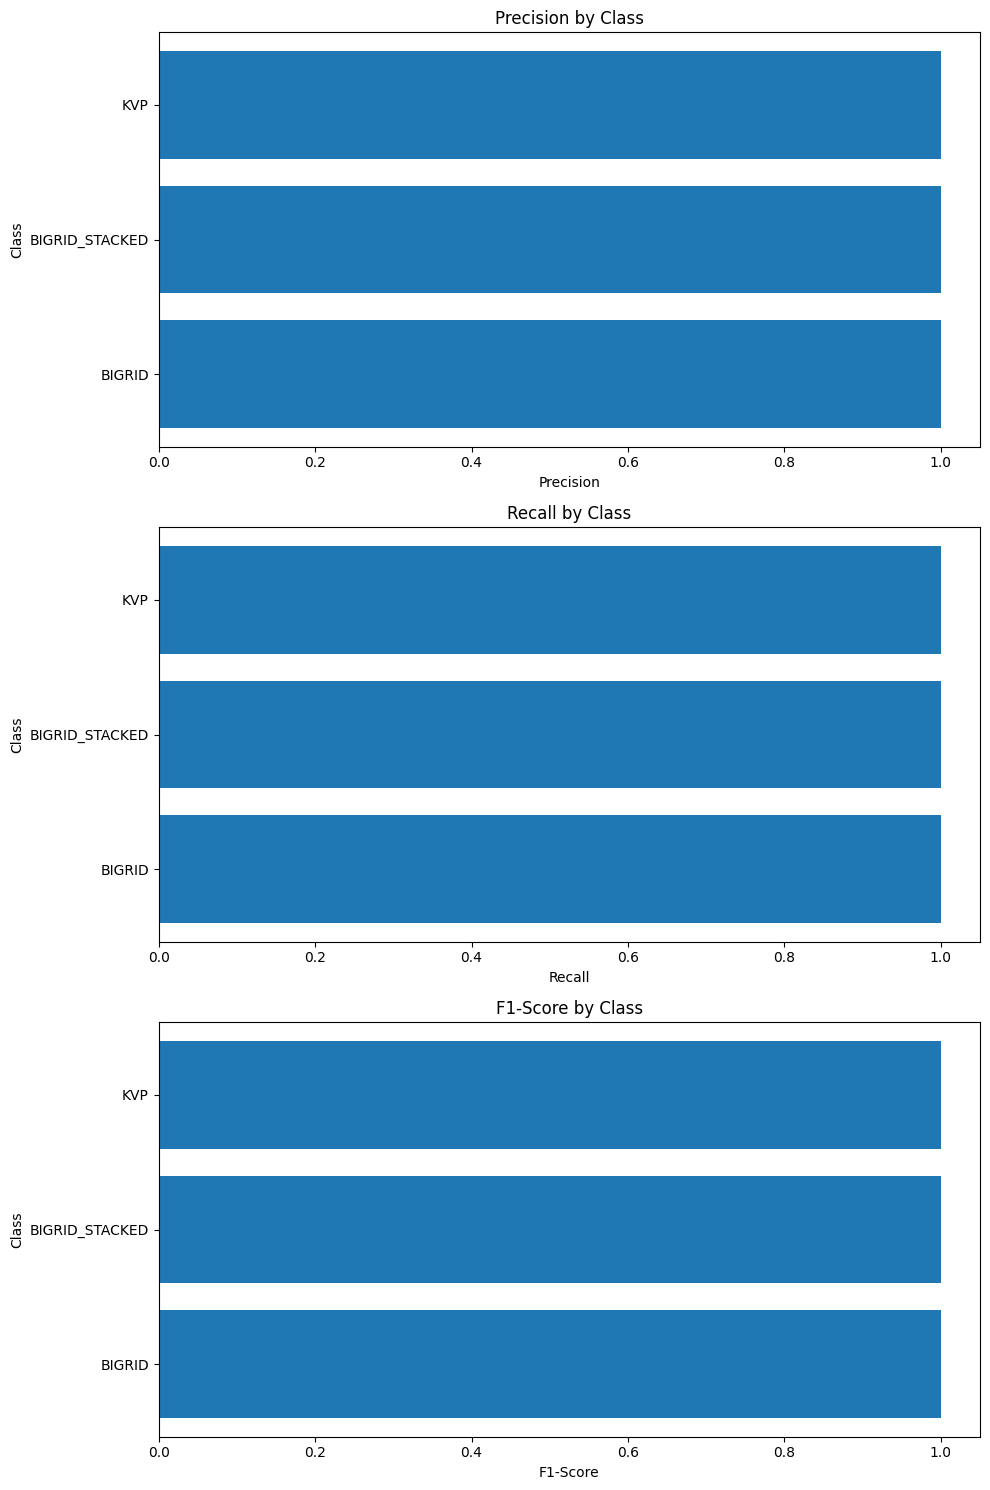

In [64]:
# Visualization
fig, ax = plt.subplots(3, 1, figsize=(10, 15))

# Precision, Recall, and F1 Scores by Class
metrics = ['Precision', 'Recall', 'F1-Score']
for i, metric in enumerate(metrics):
    ax[i].barh(labels, scores[i])
    ax[i].set_title(f'{metric} by Class')
    ax[i].set_xlabel(metric)
    ax[i].set_ylabel('Class')
plt.tight_layout()
plt.show()

In [65]:
# Load the unlabeled dataset
unlabeled_data_path = '../T_clustered_tables.csv'  # Update this path
unlabeled_data = pd.read_csv(unlabeled_data_path)

unlabeled_data.head()

,table_id,table_width,table_height,table_left,table_top,table_page,cell_count,row_count,column_count,content,...,table_title_count,table_footer_count,table_type,layout_title_text,table_type_SEMI_STRUCTURED_TABLE,table_type_STRUCTURED_TABLE,entities_int_padded,cluster_weighted,filename,table_class
0,0c1b432f-2357-423b-a088-5892a3f592b3,0.846735,0.093494,0.086168,0.253655,10,22,6,5,"[[['Operational', 'Tests']], [['Operational', ...",...,1,0,SEMI_STRUCTURED_TABLE,Low VOLTAGE AIR CIRCUIT BREAKER TEST REPORT (C...,1,0,"[[3, 3, 3, 3, 0], [4, 4, 4, 4, 0], [4, 4, 4, 4...",3,test-me.pdf,NaN
1,10462223-50f9-4e61-8688-ad77de9a59a8,0.846155,0.054527,0.087095,0.447626,14,18,4,6,"[[['Contact', 'Resistance', 'Tests']], [['Cont...",...,1,0,STRUCTURED_TABLE,Low VOLTAGE AIR CIRCUIT BREAKER TEST REPORT (C...,0,1,"[[3, 3, 1, 1, 1], [4, 4, 4, 4, 4], [4, 4, 4, 4...",11,test-me.pdf,NaN
2,12e62fc8-1085-4da2-82a7-dc1a0b8be3eb,0.847025,0.146360,0.086034,0.098383,14,34,9,5,"[[['Visual', 'Inspection']], [['Visual', 'Insp...",...,1,0,SEMI_STRUCTURED_TABLE,Low VOLTAGE AIR CIRCUIT BREAKER TEST REPORT (C...,1,0,"[[3, 3, 3, 3, 0], [4, 4, 4, 4, 0], [4, 4, 4, 4...",9,test-me.pdf,NaN
3,1347dba3-955a-4a94-8c09-5dc265274a61,0.847398,0.091269,0.085812,0.356739,14,28,5,5,"[[['Insulation', 'Resistance', 'Tests'], [], [...",...,0,0,STRUCTURED_TABLE,Low VOLTAGE AIR CIRCUIT BREAKER TEST REPORT (C...,0,1,"[[1, 1, 1, 1, 1], [4, 4, 4, 4, 4], [4, 4, 4, 4...",4,test-me.pdf,NaN
4,1441d9ff-b1c2-4efe-a158-2bb9b69ea206,0.845547,0.298446,0.087534,0.462156,7,81,16,6,"[[['Trip', 'Unit', 'Settings']], [['Trip', 'Un...",...,1,0,STRUCTURED_TABLE,Low VOLTAGE AIR CIRCUIT BREAKER TEST REPORT,0,1,"[[3, 3, 3, 3, 3], [1, 1, 1, 1, 1], [2, 2, 2, 2...",1,test-me.pdf,NaN


In [79]:
# Flatten the 'content' column using the same function defined earlier
unlabeled_data['flattened_content'] = unlabeled_data['content'].apply(flatten_content)
unlabeled_data['combined_text'] = unlabeled_data['layout_title_text'] + " " + unlabeled_data['flattened_content']

unlabeled_data.head()

,table_id,table_width,table_height,table_left,table_top,table_page,cell_count,row_count,column_count,content,...,table_footer_count,table_type,layout_title_text,table_type_SEMI_STRUCTURED_TABLE,table_type_STRUCTURED_TABLE,entities_int_padded,cluster_weighted,filename,flattened_content,combined_text
0,0c1b432f-2357-423b-a088-5892a3f592b3,0.846735,0.093494,0.086168,0.253655,10,22,6,5,"[[['Operational', 'Tests']], [['Operational', ...",...,0,SEMI_STRUCTURED_TABLE,Low VOLTAGE AIR CIRCUIT BREAKER TEST REPORT (C...,1,0,"[[3, 3, 3, 3, 0], [4, 4, 4, 4, 0], [4, 4, 4, 4...",3,test-me.pdf,Operational Tests Operational Tests Manual...,Low VOLTAGE AIR CIRCUIT BREAKER TEST REPORT (C...
1,10462223-50f9-4e61-8688-ad77de9a59a8,0.846155,0.054527,0.087095,0.447626,14,18,4,6,"[[['Contact', 'Resistance', 'Tests']], [['Cont...",...,0,STRUCTURED_TABLE,Low VOLTAGE AIR CIRCUIT BREAKER TEST REPORT (C...,0,1,"[[3, 3, 1, 1, 1], [4, 4, 4, 4, 4], [4, 4, 4, 4...",11,test-me.pdf,Contact Resistance Tests Contact Resistance Te...,Low VOLTAGE AIR CIRCUIT BREAKER TEST REPORT (C...
2,12e62fc8-1085-4da2-82a7-dc1a0b8be3eb,0.847025,0.146360,0.086034,0.098383,14,34,9,5,"[[['Visual', 'Inspection']], [['Visual', 'Insp...",...,0,SEMI_STRUCTURED_TABLE,Low VOLTAGE AIR CIRCUIT BREAKER TEST REPORT (C...,1,0,"[[3, 3, 3, 3, 0], [4, 4, 4, 4, 0], [4, 4, 4, 4...",9,test-me.pdf,Visual Inspection Visual Inspection Circui...,Low VOLTAGE AIR CIRCUIT BREAKER TEST REPORT (C...
3,1347dba3-955a-4a94-8c09-5dc265274a61,0.847398,0.091269,0.085812,0.356739,14,28,5,5,"[[['Insulation', 'Resistance', 'Tests'], [], [...",...,0,STRUCTURED_TABLE,Low VOLTAGE AIR CIRCUIT BREAKER TEST REPORT (C...,0,1,"[[1, 1, 1, 1, 1], [4, 4, 4, 4, 4], [4, 4, 4, 4...",4,test-me.pdf,Insulation Resistance Tests Pole #1 Pole #2 ...,Low VOLTAGE AIR CIRCUIT BREAKER TEST REPORT (C...
4,1441d9ff-b1c2-4efe-a158-2bb9b69ea206,0.845547,0.298446,0.087534,0.462156,7,81,16,6,"[[['Trip', 'Unit', 'Settings']], [['Trip', 'Un...",...,0,STRUCTURED_TABLE,Low VOLTAGE AIR CIRCUIT BREAKER TEST REPORT,0,1,"[[3, 3, 3, 3, 3], [1, 1, 1, 1, 1], [2, 2, 2, 2...",1,test-me.pdf,Trip Unit Settings Trip Unit Settings Ele...,Low VOLTAGE AIR CIRCUIT BREAKER TEST REPORT Tr...


In [69]:
data.to_csv('labeled_data.csv', index=False)
unlabeled_data.to_csv('unlabeled_data.csv', index=False)

In [80]:
unlabeled_data['entities_int_padded'] = unlabeled_data['entities_int_padded'].apply(lambda x: ast.literal_eval(x))
# After conversion, flatten the lists of lists into a 2D numpy array
flattened_entities_test = np.array([np.concatenate(row) for row in unlabeled_data['entities_int_padded']])

ValueError: malformed node or string: [[3, 3, 3, 3, 0], [4, 4, 4, 4, 0], [4, 4, 4, 4, 0], [4, 4, 4, 4, 0], [4, 4, 4, 4, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]

In [68]:
# Vectorize the combined textual data using the fitted TF-IDF vectorizer from before
# Note: Use transform() instead of fit_transform() because we want to use the same vocabulary as the training data
combined_text_tfidf_unlabeled = tfidf_vectorizer.transform(unlabeled_data['combined_text'])

# Prepare and scale the numerical features
X_numerical_unlabeled = unlabeled_data[feature_columns]
X_numerical_scaled_unlabeled = scaler.transform(X_numerical_unlabeled)  # Use the same scaler object from the training phase

# Combine the textual and numerical features
X_combined_unlabeled = hstack([flattened_entities_test, combined_text_tfidf_unlabeled, X_numerical_scaled_unlabeled])

# Use the trained model to predict the 'table_class' for the unlabeled data
unlabeled_predictions = model.predict(X_combined_unlabeled)

# Optionally, add the predictions back to the unlabeled dataframe to inspect them
unlabeled_data['predicted_table_class'] = unlabeled_predictions

# Show the dataframe with predictions
print(unlabeled_data[['table_id', 'predicted_table_class']].head())  # Adjust columns as needed for your review

# Save the dataframe with predictions to a new CSV file if desired
unlabeled_data.to_csv('unlabeled_tables_with_predictions.csv', index=False)


ValueError: X has 1093 features, but RandomForestClassifier is expecting 1109 features as input.

In [70]:
import pandas as pd

# Load the CSV files
unlabeled_data_df = unlabeled_data
labeled_data_df = data

# Get the column names
unlabeled_data_columns = set(unlabeled_data_df.columns)
labeled_data_columns = set(labeled_data_df.columns)

# Identify missing and additional features
missing_features_in_unlabeled = labeled_data_columns - unlabeled_data_columns
additional_features_in_unlabeled = unlabeled_data_columns - labeled_data_columns

print("Missing features in unlabeled data:", missing_features_in_unlabeled)
print("Additional features in unlabeled data:", additional_features_in_unlabeled)


Missing features in unlabeled data: set()
Additional features in unlabeled data: set()


In [74]:
print(unlabeled_data_df.dtypes)

table_id                             object
table_width                         float64
table_height                        float64
table_left                          float64
table_top                           float64
table_page                            int64
cell_count                            int64
row_count                             int64
column_count                          int64
content                              object
entities                             object
child_count                           int64
merged_cell_count                     int64
table_title_count                     int64
table_footer_count                    int64
table_type                           object
layout_title_text                    object
table_type_SEMI_STRUCTURED_TABLE      int64
table_type_STRUCTURED_TABLE           int64
entities_int_padded                  object
cluster_weighted                      int64
filename                             object
table_class                     

In [75]:
print(labeled_data_df.dtypes)

table_id                             object
table_width                         float64
table_height                        float64
table_left                          float64
table_top                           float64
table_page                            int64
cell_count                            int64
row_count                             int64
column_count                          int64
content                              object
entities                             object
child_count                           int64
merged_cell_count                     int64
table_title_count                     int64
table_footer_count                    int64
table_type                           object
layout_title_text                    object
table_type_SEMI_STRUCTURED_TABLE      int64
table_type_STRUCTURED_TABLE           int64
entities_int_padded                  object
cluster_weighted                      int64
filename                             object
table_class                     

In [77]:
unlabeled_data = unlabeled_data_df.drop(columns=['table_class'], errors='ignore')